In [2]:
import torch,torchvision

torchvision.__version__,torch.__version__

('0.15.2+cu118', '2.0.1+cu118')

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np

In [4]:
download_address = r"https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from pathlib import Path
import zipfile 
import requests
import os

data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
    print("already downloaded")
else:
    print("downloading")
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(download_address)
        f.write(request.content)
        
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print("extracting")
        zip_ref.extractall(image_path)
    os.remove(data_path / "pizza_steak_sushi.zip")
    

already downloaded


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"
BATCH_SIZE = 32

In [8]:
# Creating a transform for torchvision.models (manual creation)

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [9]:
from going_modular.going_modular import data_setup, engine

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                              test_dir,
                                                                              manual_transforms,
                                                                              BATCH_SIZE
                                                                              )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x19484e1d4f0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
# Creating a transform for torchvision.models (auto creation)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir,
                                                                              test_dir,
                                                                              auto_transforms,
                                                                              BATCH_SIZE
                                                                              )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x19484f07ac0>,
 ['pizza', 'steak', 'sushi'])

In [13]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
summary(model=model,
       input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=17,
       row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 1000]        --                True
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7]  --                True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --                True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] 864               True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] 64                True
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                True
│    │    └─MBConv (0)       

In [15]:
# Freeze all base layers in the "features" section of the model
for param in model.features.parameters():
    param.requires_grad = False

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2,inplace= True),
        torch.nn.Linear(in_features=1280,
                       out_features=output_shape,
                       bias=True)).to(device)


In [17]:
summary(
        model,
    input_size=(32,3,224,224),
    verbose = 0,
    col_names=["input_size","output_size","num_params","trainable"],
    col_width=16,
    row_settings=["var_names"]
    
)

Layer (type (var_name))                                      Input Shape      Output Shape     Param #          Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3]          --               Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --               False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --               False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)            False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)             False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --               --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --               False
│    │    └─MBConv (0)           

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
from going_modular.going_modular import engine
from time import perf_counter

start_time = perf_counter()

results = engine.train(model,
            train_dataloader,
            test_dataloader,
            optimizer,
            loss_fn,
            epochs=5,
            device=device)

end_time = perf_counter()
print(f"total time took {end_time-start_time} on {device}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0476 | train_acc: 0.3789 | test_loss: 0.8554 | test_acc: 0.7737
Epoch: 2 | train_loss: 0.9175 | train_acc: 0.6406 | test_loss: 0.7150 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.7876 | train_acc: 0.7617 | test_loss: 0.6468 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.6350 | train_acc: 0.9141 | test_loss: 0.5974 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6705 | train_acc: 0.7344 | test_loss: 0.5903 | test_acc: 0.8153
total time took 21.178271799999493 on cuda


[info] downloading helper functions


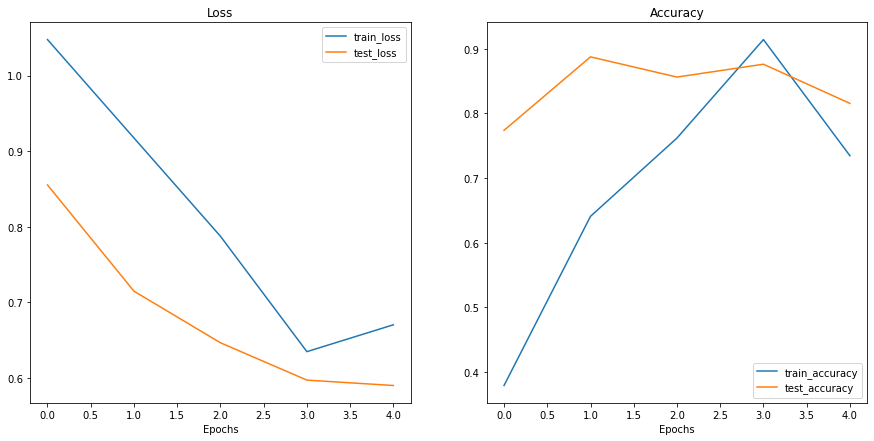

In [20]:
try:
    from helper_functions import plot_loss_curves
except:
    import requests
    print(f"[info] downloading helper functions")
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)                       
    from helper_functions import plot_loss_curves
                               
plot_loss_curves(results)

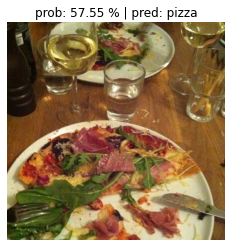

In [21]:
from typing import List, Tuple
from PIL import Image
from pathlib import Path

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    image = Image.open(image_path)
    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
        
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        tranformed_image = image_transform(image).unsqueeze(0)
        
        target_image_pred = model(tranformed_image.to(device))
        
        tranformed_image_prob = torch.softmax(target_image_pred, dim=1)
        tranformed_image_label = torch.argmax(tranformed_image_prob, dim=1)

    plt.figure()
    plt.imshow(image)
    plt.title(f"prob: {tranformed_image_prob.max()*100 :.2f} % | pred: {class_names[tranformed_image_label]}")
    plt.axis(False);

    
img_file = data_path / "971934.jpg"   
pred_and_plot_image(model,
                    img_file,
                    class_names,
                    (224,224)
                   )

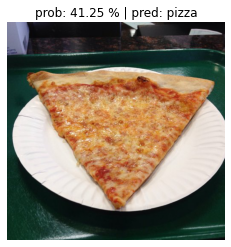

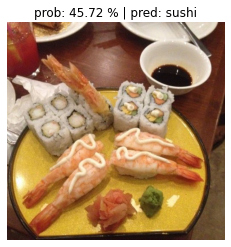

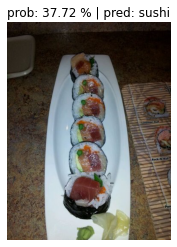

In [22]:
import random
import os

random_image_paths = random.sample(list(Path(test_dir).glob("*/*.jpg")),k=3)

for random_image_path in random_image_paths:
    pred_and_plot_image(model,
                       random_image_path,
                        class_names,
                        (224,224)
                       )  

In [23]:
random_sample_index = random.randint(0,len(list(Path(test_dir).glob("*/*.jpg"))))
random_sample_index

44

In [24]:
from PIL import Image
image_paths = list(Path(test_dir).glob("*/*.jpg"))
str(image_paths[random_sample_index])
Path(str(image_paths[random_sample_index])).parent.stem
# image = Image.open(str(image_paths[random_sample_index]))
# image

'sushi'

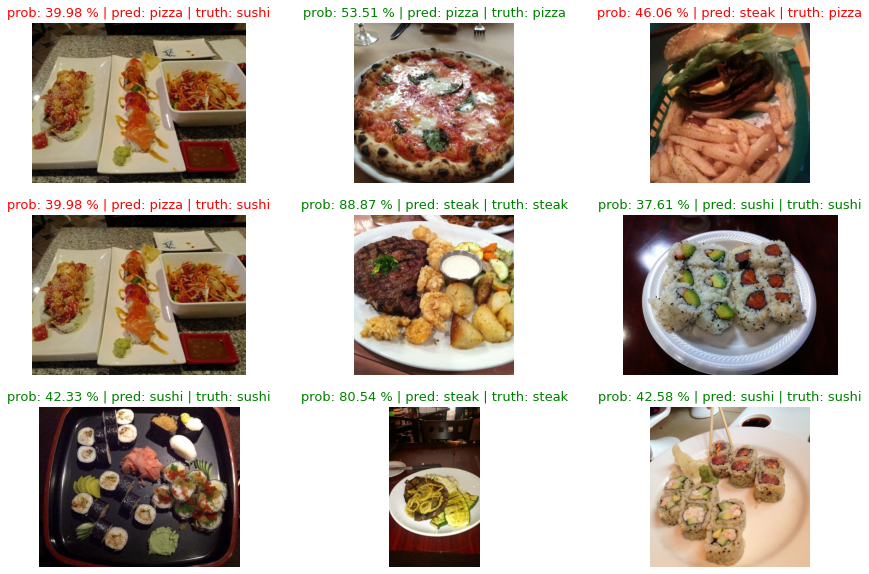

In [25]:
###with subplot

from typing import List, Tuple
from PIL import Image
from pathlib import Path

def pred_and_plot_image(model: torch.nn.Module,
                        test_dir: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    image_paths = list(Path(test_dir).glob("*/*.jpg"))
    
    plt.figure(figsize=(15,10))
    for i in range(1,10):
        row,col = 3, 3
        
        random_sample_index = random.randint(0,len(image_paths))
        
        truth_label = Path(str(image_paths[random_sample_index])).parent.stem

        image = Image.open(str(image_paths[random_sample_index]))

        if transform is not None:
            image_transform = transform
        else:
            image_transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])

        model.to(device)

        model.eval()
        with torch.inference_mode():
            tranformed_image = image_transform(image).unsqueeze(0)

            target_image_pred = model(tranformed_image.to(device))

            tranformed_image_prob = torch.softmax(target_image_pred, dim=1)
            tranformed_image_label = torch.argmax(tranformed_image_prob, dim=1)

        
        plt.subplot(row,col,i)
        plt.imshow(image)
        if truth_label == class_names[tranformed_image_label]:
            plt.title(f"prob: {tranformed_image_prob.max()*100 :.2f} % | pred: {class_names[tranformed_image_label]} | truth: {truth_label}",fontsize=13,c="g")
        else:
            plt.title(f"prob: {tranformed_image_prob.max()*100 :.2f} % | pred: {class_names[tranformed_image_label]} | truth: {truth_label}",fontsize=13,c="r")
        plt.axis(False);

    
img_file = Path(test_dir)    
pred_and_plot_image(model,
                    img_file,
                    class_names,
                    (224,224)
                   )

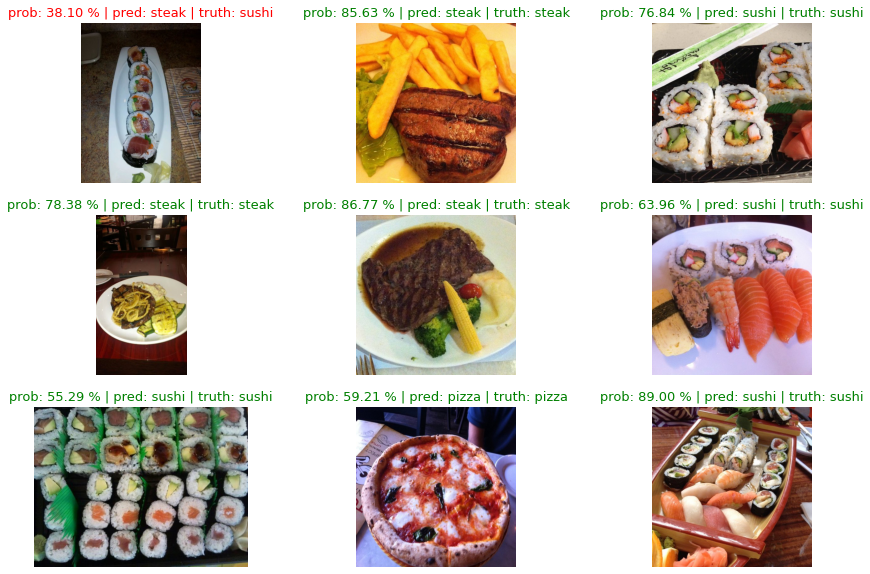

In [26]:
pred_and_plot_image(model,
                    img_file,
                    class_names,
                    (224,224),
                    auto_transforms
                   )

### Make predictions on the entire test dataset with the model

In [28]:
#to do

In [ ]:
truth_labels = [y for X, y in test_dataloader]
truth_labels = torch.cat(pred_labels)
truth_labels

### make confusion matrix with test pred and truth labels

In [ ]:
#to do